# Section 1: Initial Setup and Data Loading¶

In [1]:
# Essential imports for our EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from typing import Optional, List

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set style and color palette
sns.set_theme(style="darkgrid")
COLOR_PALETTE = sns.color_palette("viridis", n_colors=10)

print("📊 Starting Commodity Price Forecasting EDA")
print("=" * 50)

📊 Starting Commodity Price Forecasting EDA


## Memory Saving

In [47]:
# ===================================================================================
# ✅ Complete Data Loading Cell for Mitsui Commodity Prediction Challenge
# ===================================================================================
import os
import pandas as pd
import numpy as np
import warnings

# Utility to list files for debugging
print("Available files under /kaggle/input/mitsui-commodity-prediction-challenge:")
print(os.listdir("/kaggle/input/mitsui-commodity-prediction-challenge"))

# Define paths
BASE = "/kaggle/input/mitsui-commodity-prediction-challenge"
TRAIN_CSV = f"{BASE}/train.csv"
TEST_CSV = f"{BASE}/test.csv"
LABELS_CSV = f"{BASE}/train_labels.csv"
PAIRS_CSV = f"{BASE}/target_pairs.csv"
LAGGED_DIR = f"{BASE}/lagged_test_labels"

# ================================================================================
# Memory optimization (NaN-safe)
def reduce_mem_usage(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if df[col].isnull().all(): continue
        col_type = df[col].dtype
        c_min, c_max = df[col].min(skipna=True), df[col].max(skipna=True)
        if col_type != object and col_type.name != 'category':
            if str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if not np.isnan(c_min) and not np.isnan(c_max):
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory downcast: {start_mem:.2f} → {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df

# # ================================================================================
# # Loading
# train = reduce_mem_usage(pd.read_csv(TRAIN_CSV), verbose=True)
# test = reduce_mem_usage(pd.read_csv(TEST_CSV), verbose=True)
# labels = reduce_mem_usage(pd.read_csv(LABELS_CSV), verbose=True)
# pairs = reduce_mem_usage(pd.read_csv(PAIRS_CSV), verbose=True)

# # Load all lagged test labels
# lagged = {}
# for fname in sorted(os.listdir(LAGGED_DIR)):
#     if fname.endswith(".csv"):
#         lag = fname.replace("test_labels_lag_", "").replace(".csv", "")
#         path = os.path.join(LAGGED_DIR, fname)
#         lagged[f"lag_{lag}"] = reduce_mem_usage(pd.read_csv(path), verbose=True)

# print("Loaded lagged test label files:", list(lagged.keys()))

# # ================================================================================
# # Confirm variables are defined
# print(f"train: {train.shape}, labels: {labels.shape}, pairs: {pairs.shape}")

Available files under /kaggle/input/mitsui-commodity-prediction-challenge:
['lagged_test_labels', 'target_pairs.csv', 'train_labels.csv', 'train.csv', 'test.csv', 'kaggle_evaluation']
Memory downcast: 8.16 → 2.40 MB (70.6% reduction)
Memory downcast: 0.38 → 0.11 MB (70.0% reduction)
Memory downcast: 6.22 → 1.55 MB (75.0% reduction)
Memory downcast: 0.01 → 0.03 MB (-224.8% reduction)
Memory downcast: 0.07 → 0.02 MB (74.9% reduction)
Memory downcast: 0.07 → 0.02 MB (74.9% reduction)
Memory downcast: 0.07 → 0.02 MB (74.9% reduction)
Memory downcast: 0.07 → 0.02 MB (74.9% reduction)
Loaded lagged test label files: ['lag_1', 'lag_2', 'lag_3', 'lag_4']
train: (1917, 558), labels: (1917, 425), pairs: (424, 3)


## Without Memory saving
##### Saw weird behaviors when calculating mean, var
##### e.g.  train['LME_AH_Close'].var() comes out as inf

In [2]:
# Define paths
BASE = "/kaggle/input/mitsui-commodity-prediction-challenge"
TRAIN_CSV = f"{BASE}/train.csv"
TEST_CSV = f"{BASE}/test.csv"
LABELS_CSV = f"{BASE}/train_labels.csv"
PAIRS_CSV = f"{BASE}/target_pairs.csv"
LAGGED_DIR = f"{BASE}/lagged_test_labels"

# ================================================================================
# Loading
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)
labels = pd.read_csv(LABELS_CSV)
pairs = pd.read_csv(PAIRS_CSV)


# Generate Targets

In [3]:
def generate_log_returns(data: pd.Series, lag: int):
    log_returns = pd.Series(np.nan, index=data.index)

    # Compute log returns based on the rules
    for t in range(len(data)):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                log_returns.iloc[t] = np.log(data.iloc[t + lag + 1] / data.iloc[t + 1])
            except Exception:
                log_returns.iloc[t] = np.nan
    return log_returns

def generate_log_returns_dataframe(data: pd.DataFrame, lag: int):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        try:
            log_returns = np.log(data / data.shift(lag))
        except Exception:
            log_returns = data * np.nan
    return log_returns

def generate_targets(column_a: pd.Series, column_b: pd.Series, lag: int) -> pd.Series:
    a_returns = generate_log_returns(column_a, lag)
    b_returns = generate_log_returns(column_b, lag)
    return a_returns - b_returns

# generate_targets(train['LME_CA_Close'], train['US_Stock_CCJ_adj_close'], 4)

# EDA

In [29]:
# Understanding the timeseries data

train_cols = [col.split("_")[0] for col in train.columns if col != 'date_id']

train_cols_counter = Counter(train_cols)

print("=" * 50)
print("\n# Instrument Categories:")
print("\n".join([f"{idx}. {item[0]}: {item[1]} instruments" for idx, item in enumerate(train_cols_counter.items())]))

print("\n\n", "="*50)
print("\n# Sample Instruments:")
for col_category in train_cols_counter:
    print(col_category, " :")
    print(" , ".join([col for col in train.columns if col.startswith(col_category)][:10]))


# Instrument Categories:
0. LME: 4 instruments
1. JPX: 40 instruments
2. US: 475 instruments
3. FX: 38 instruments



# Sample Instruments:
LME  :
LME_AH_Close , LME_CA_Close , LME_PB_Close , LME_ZS_Close
JPX  :
JPX_Gold_Mini_Futures_Open , JPX_Gold_Rolling-Spot_Futures_Open , JPX_Gold_Standard_Futures_Open , JPX_Platinum_Mini_Futures_Open , JPX_Platinum_Standard_Futures_Open , JPX_RSS3_Rubber_Futures_Open , JPX_Gold_Mini_Futures_High , JPX_Gold_Rolling-Spot_Futures_High , JPX_Gold_Standard_Futures_High , JPX_Platinum_Mini_Futures_High
US  :
US_Stock_ACWI_adj_open , US_Stock_AEM_adj_open , US_Stock_AG_adj_open , US_Stock_AGG_adj_open , US_Stock_ALB_adj_open , US_Stock_AMP_adj_open , US_Stock_BCS_adj_open , US_Stock_BKR_adj_open , US_Stock_BND_adj_open , US_Stock_BNDX_adj_open
FX  :
FX_AUDJPY , FX_AUDUSD , FX_CADJPY , FX_CHFJPY , FX_EURAUD , FX_EURGBP , FX_EURJPY , FX_EURUSD , FX_GBPAUD , FX_GBPJPY


In [55]:
def missing_value_analysis(df: pd.DataFrame, title):
    print(f"\n🔎 MISSING VALUE ANALYSIS: {title}")
    df_missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).apply(lambda x: "{:,.2f}%".format(x))
    display(df_missing.T)
    

def plot_feature_distributions(df: pd.DataFrame, cols: Optional[List[str]] = None,
                             n: int = 12, bins: int = 60, title: Optional[str] = None):
    if cols is None:
        # pick top features with max variance
        # Features with larger variances generally contain more information
        cols = df.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:n].tolist()

    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    ax = ax.flatten()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        for i, col in enumerate(cols):
            sns.histplot(df[col], bins=bins, kde=True, color=COLOR_PALETTE[i % len(COLOR_PALETTE)], ax=ax[i])

            # calculate median, skewness, kurtosis
            median = df[col].median()
            skewness = df[col].skew()
            kurtosis = df[col].kurt()
            
            ax[i].set_title(label=f"median={np.round(median,2)}, skew={np.round(skewness,2)}, kurt={np.round(kurtosis,2)}", fontsize=11)
            ax[i].grid(alpha=0.3)

        if title:
            plt.suptitle(title)

    plt.tight_layout()
    plt.show()

def plot_target_distributions(df: pd.DataFrame, n: int = 12, bins: int = 60):
    cols = [col for col in labels.columns if col.startswith("target_")][:n]
    plot_feature_distributions(df=df, cols=cols, n=n, title="Target Distributions of first 12 targets")

def plot_feature_correlation_matrix(df: pd.DataFrame, cols: Optional[List[str]] = None,
                                   n: int = 12, title: Optional[str] = None):
    if cols is None:
        # pick top features with max variance
        # Features with larger variances generally contain more information
        cols = df.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:n].tolist()

    corr = df[cols].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def plot_target_feature_correlation_matrix(train: pd.DataFrame, labels: pd.DataFrame, pairs: pd.DataFrame,
                                          n: int = 12, title: Optional[str] = None,
                                          correlation_threshold: float = 0.70,
                                          ax: plt.Axes = None):
    
    # Compute correlation
    df1 = train[[col for col in train.columns if col != 'date_id']] 
    
    # select label columns to run correlation on
    select_cols = []

    for lag in pairs['lag'].unique():
        targets = pairs[pairs['lag'] == lag]['target']
        random_cols = targets.iloc[(np.random.rand(10)*(len(targets)-1)).astype(int)].tolist()
        select_cols.extend(random_cols)

    select_cols = list(set(select_cols))
    select_pairs = pairs.set_index('target').loc[select_cols]['pair'] + "_lag_" + pairs.set_index('target').loc[select_cols]['lag'].astype(str)
    
    corr = pd.DataFrame(index = df1.columns, columns=select_pairs)
    
    for idx, col in enumerate(select_cols):
        corr.loc[df1.columns, select_pairs[idx]] = df1.corrwith(labels[col])

    high_correlation_data = corr[corr.abs() > correlation_threshold].replace(0, np.nan)
    high_correlation_data.dropna(how='all', axis=0, inplace=True)
    high_correlation_data.dropna(how='all', axis=1, inplace=True)

    if not(high_correlation_data.empty):
        # add an extra column or row if the len of any = 1
        if len(high_correlation_data.columns) == 1:
            high_correlation_data["dummy"] = 0
        if len(high_correlation_data.index) == 1:
            high_correlation_data.loc["dummy"] = 0

        high_correlation_data = high_correlation_data.astype(float)

        if ax is None:
            # Set up the matplotlib figure
            f, axes = plt.subplots(figsize=(11, 9))
    
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
                                     
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(high_correlation_data, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f",
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
        
        if ax is None:
            plt.tight_layout()
            plt.show()
    else:
        print(f"\n❗no strong correlation found for the set threshold of {int(correlation_threshold*100)}%\n")

        if ax is None:
            # Set up the matplotlib figure
            f, ax = plt.subplots(figsize=(11,9))

        # stack correlation dataframe
        corr_stack = corr.stack()
        
        # Display the histogram of all correlations
        sns.histplot(corr_stack, kde=True, ax=ax)

        # calculate median, skewness, kurtosis
        median = corr_stack.median()
        skewness = corr_stack.skew()
        kurtosis = corr_stack.kurt()
        
        ax.set_title(label=f"median={np.round(median,2)}, skew={np.round(skewness,2)}, kurt={np.round(kurtosis,2)}", fontsize=11)
        ax.grid(alpha=0.3)
        
        if ax is None:
            plt.tight_layout()
            plt.show()

In [68]:
missing_value_analysis(train, "TRAIN")
missing_value_analysis(test, "TEST")
missing_value_analysis(labels, "TRAIN_LABELS")


🔎 MISSING VALUE ANALYSIS: TRAIN


US_Stock_GOLD_adj_volume    87.06%
US_Stock_GOLD_adj_low       87.06%
US_Stock_GOLD_adj_high      87.06%
US_Stock_GOLD_adj_open      87.06%
US_Stock_GOLD_adj_close     87.06%
                             ...  
FX_NZDUSD                    0.00%
FX_USDCHF                    0.00%
FX_USDJPY                    0.00%
FX_ZARJPY                    0.00%
FX_ZARGBP                    0.00%
Length: 558, dtype: object


🔎 MISSING VALUE ANALYSIS: TEST


US_Stock_GOLD_adj_high      100.00%
US_Stock_GOLD_adj_low       100.00%
US_Stock_GOLD_adj_close     100.00%
US_Stock_GOLD_adj_volume    100.00%
US_Stock_GOLD_adj_open      100.00%
                             ...   
FX_USDCHF                     0.00%
FX_USDJPY                     0.00%
FX_ZARJPY                     0.00%
FX_ZARUSD                     0.00%
is_scored                     0.00%
Length: 559, dtype: object


🔎 MISSING VALUE ANALYSIS: TRAIN_LABELS


target_270    17.94%
target_285    17.94%
target_317    17.94%
target_225    17.94%
target_238    17.94%
               ...  
target_86      4.49%
target_87      4.49%
target_212     0.00%
target_318     0.00%
date_id        0.00%
Length: 425, dtype: object


# Distributions of train dataset with largest variances



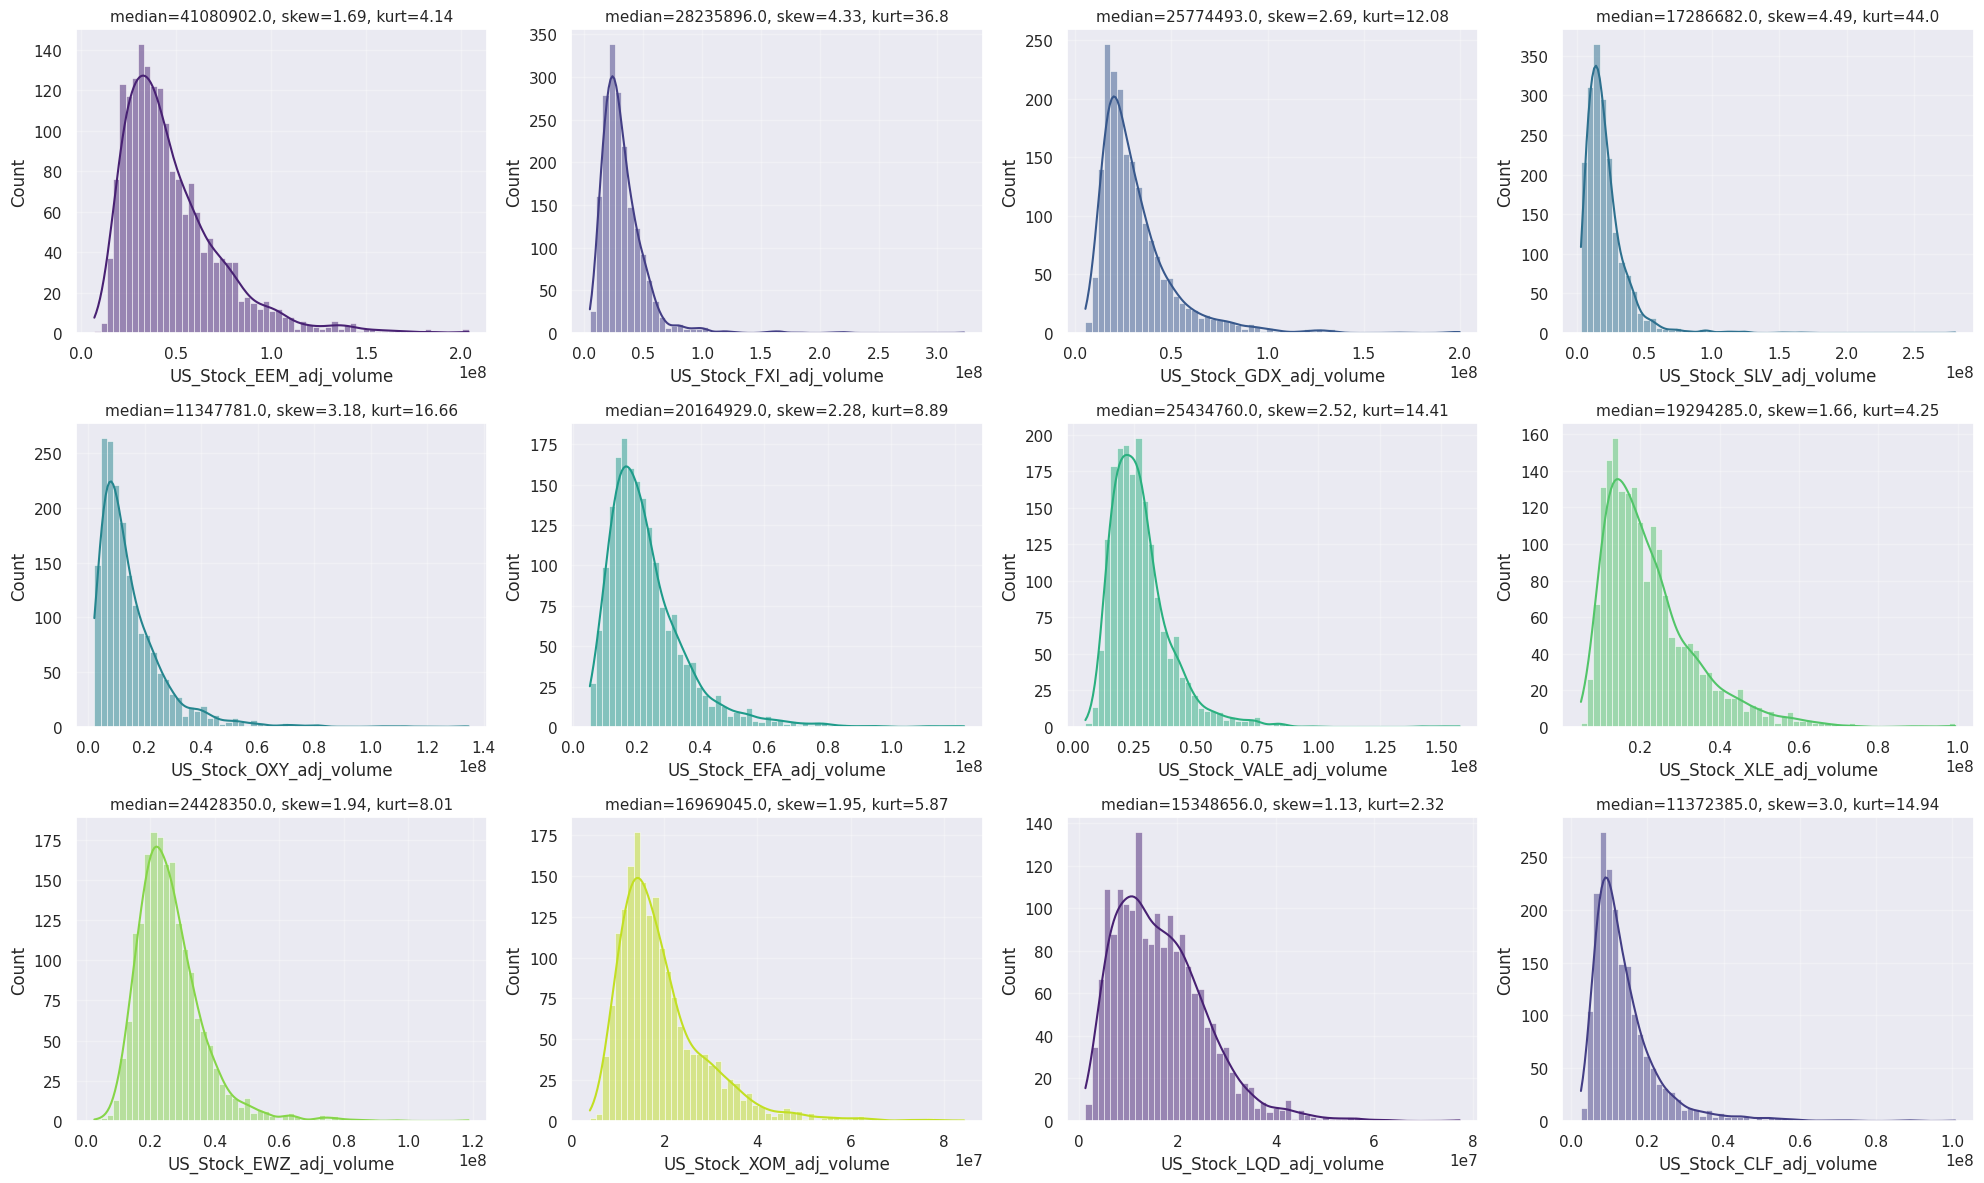

In [124]:
print("\n# 🔎Distributions of train dataset with largest variances\n")
plot = plot_feature_distributions(train)


# 🔎Distributions of train labels dataset with largest variances



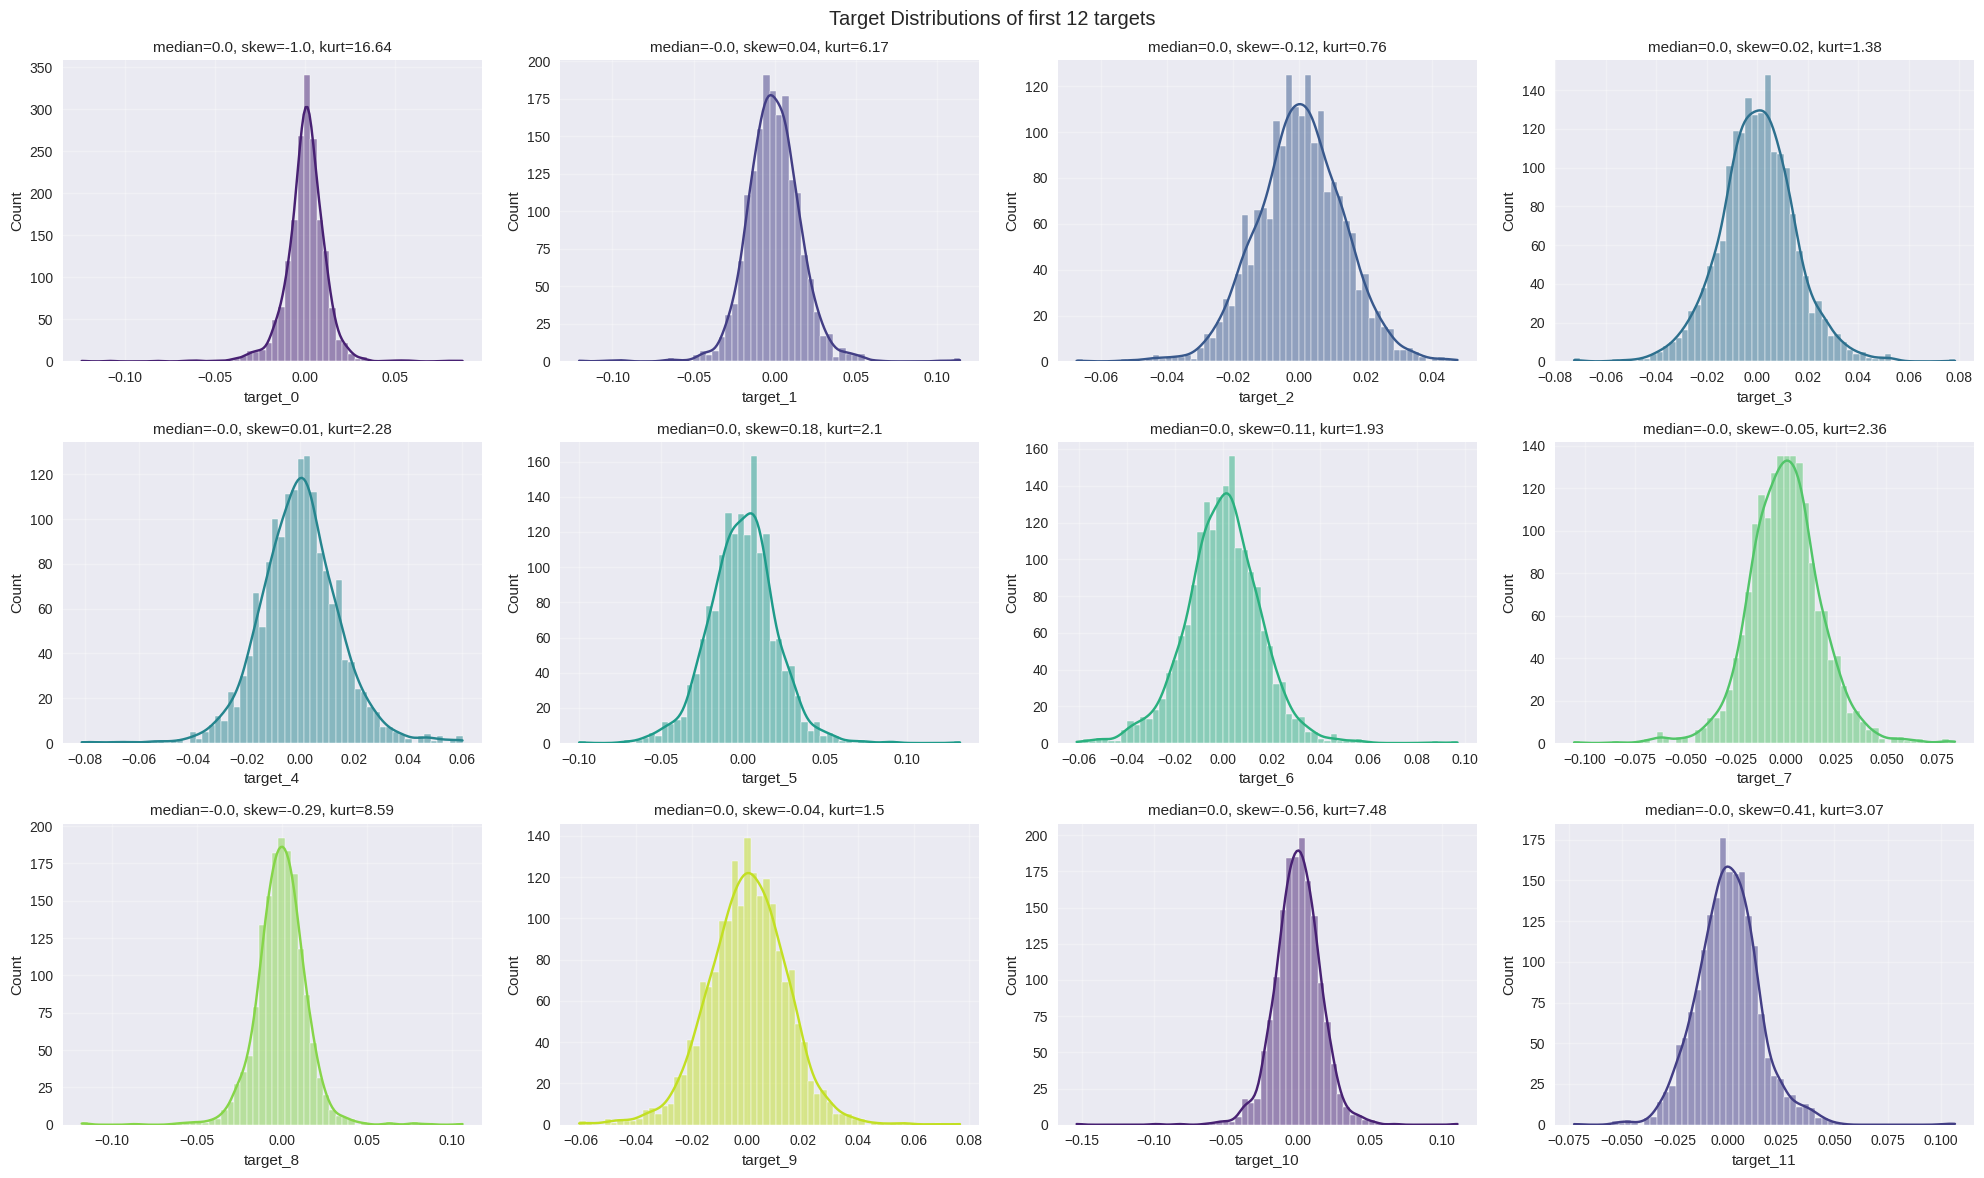

In [30]:
print("\n# 🔎Distributions of train labels dataset with largest variances\n")
plot_target_distributions(labels)


# Correlation Matrix of top 12 features by variance 



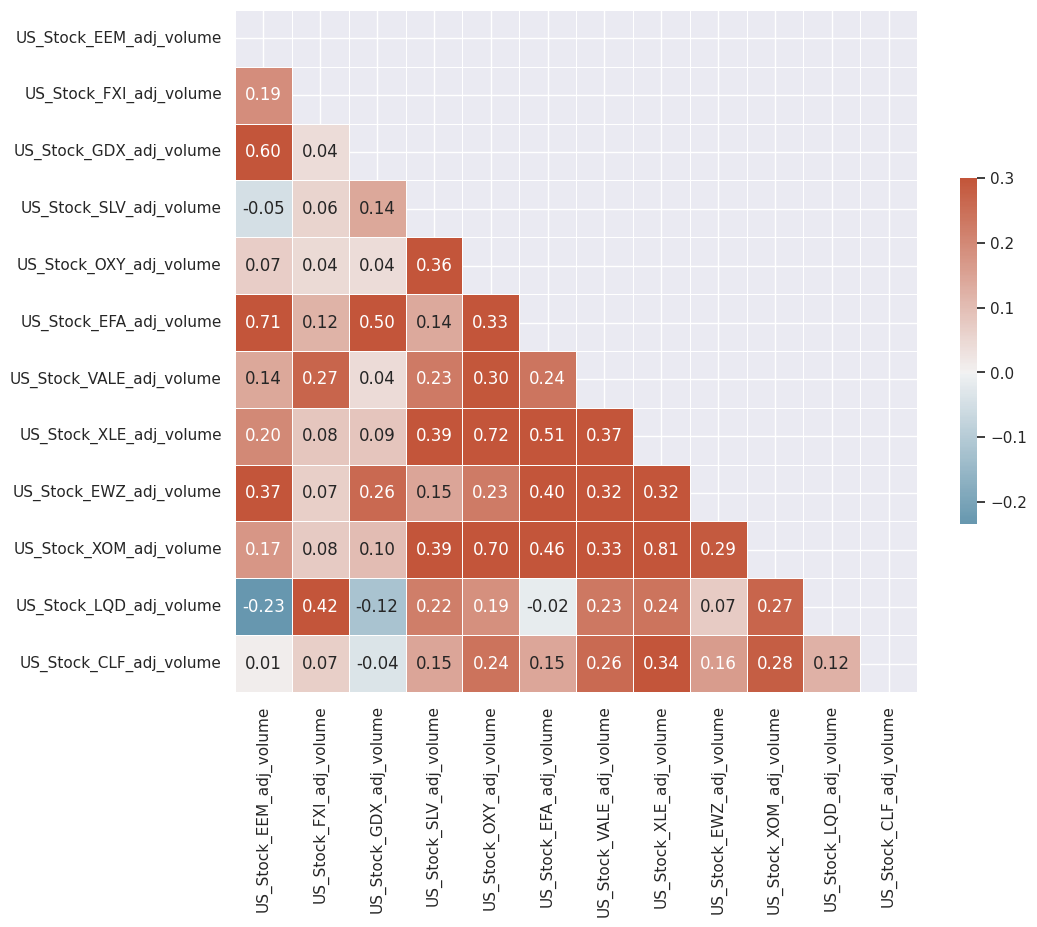

In [148]:
print("\n# 🔎Correlation Matrix of top 12 features by variance \n")
plot_feature_correlation_matrix(train)#, cols=['US_Stock_VYM_adj_close','LME_ZS_Close','US_Stock_VTV_adj_close'])

# 🔎Features with very high correlation



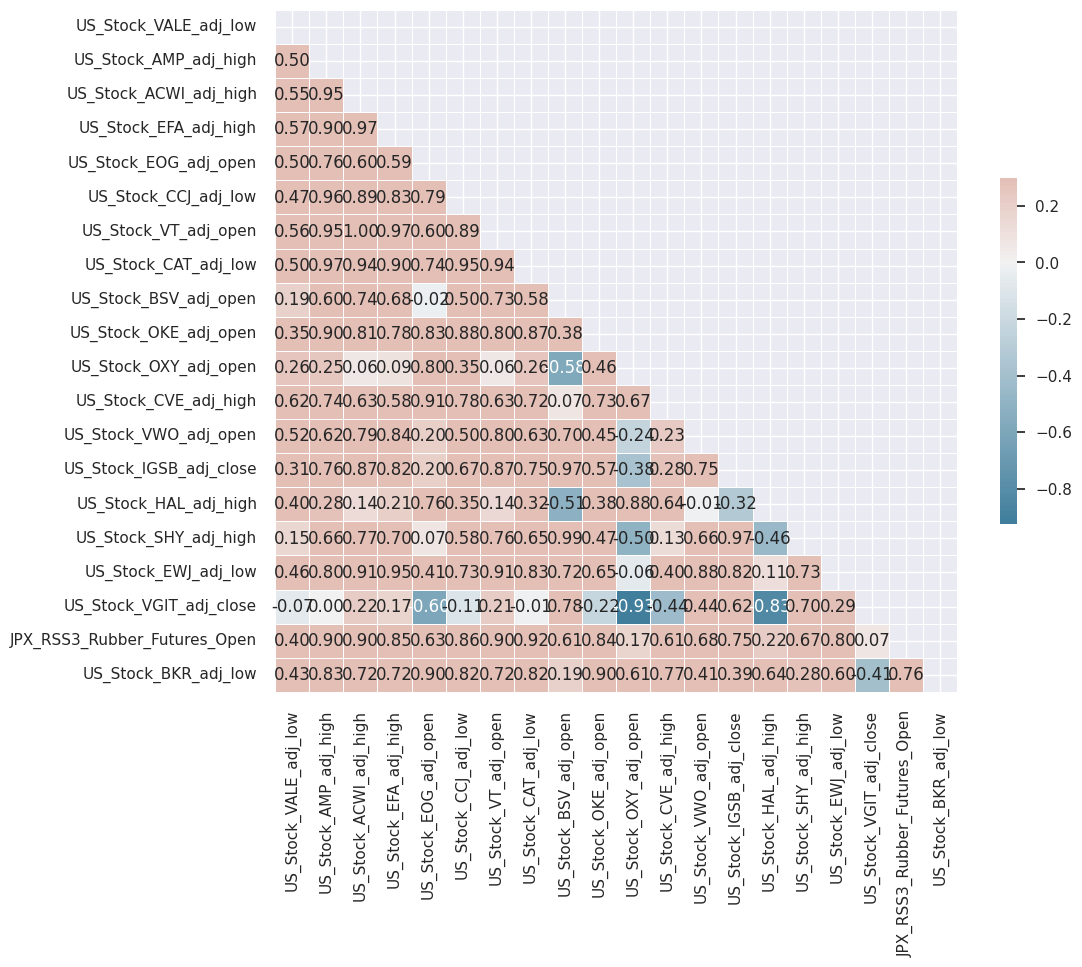

In [251]:
print("\n# 🔎Correlation matrix for features with very high correlation\n")

def fetch_high_correlation_columns(df: pd.DataFrame, correlation_threshold: float):
    correlation_data = train.corr()
    
    high_corelation_columns = []

    # loop through correlation matrix to fetch the high correlation columns
    for i in range(len(correlation_data.columns)-1):
        for j in range(i+1, len(correlation_data.columns)):
            coli = correlation_data.columns[i]
            colj = correlation_data.columns[j]
            if (np.abs(correlation_data.loc[coli, colj]) > correlation_threshold):
                high_corelation_columns.extend([coli, colj])
    
    high_corelation_columns = list(set(high_corelation_columns))

    return high_corelation_columns

cols = fetch_high_correlation_columns(train, 0.99)

plot_feature_correlation_matrix(train, cols=cols[:20])

CPU times: user 9.91 s, sys: 51 ms, total: 9.96 s
Wall time: 5.04 s


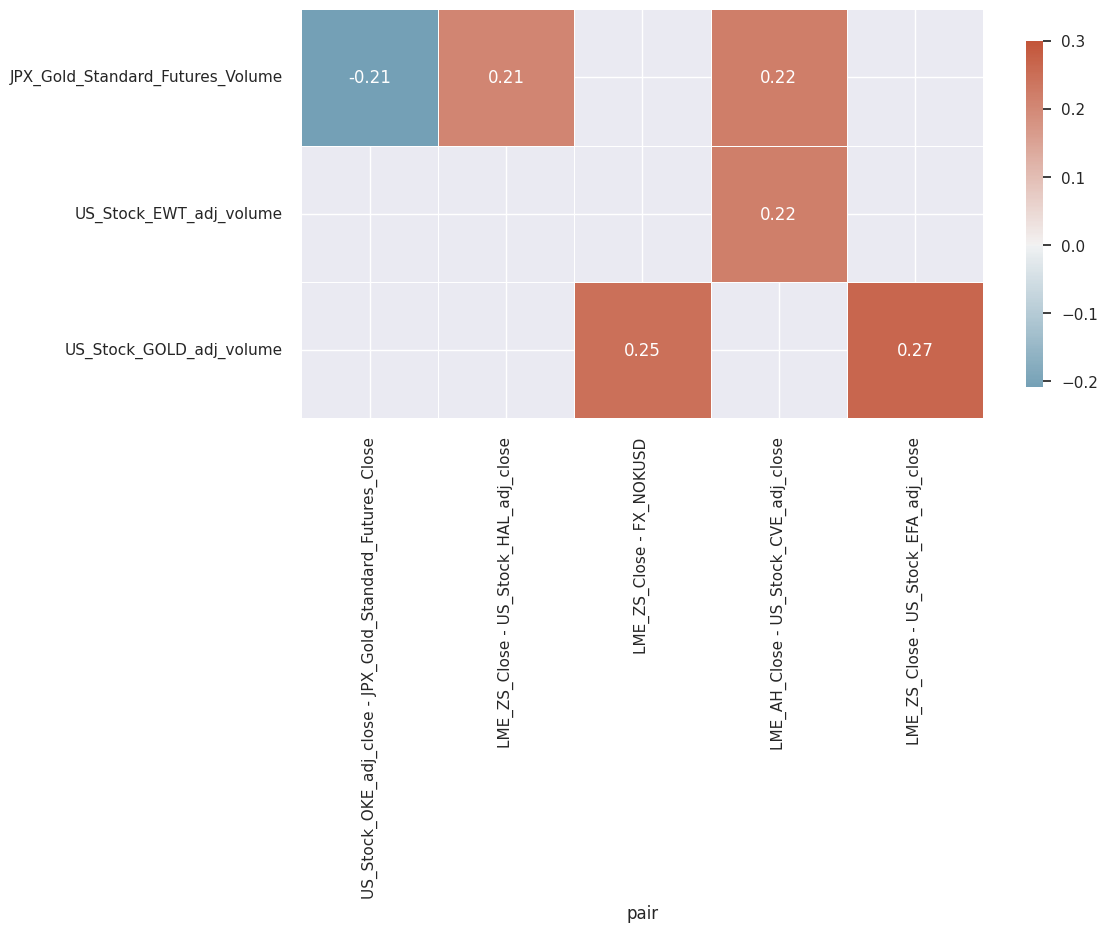

In [202]:
%%time
print(f"\n# 🔎Target - Feature correlation matrix with a correlation threshold: {correlation_threshold}\n")

plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.2)


🔎 Checking if taking log returns have any impact on the correlation distribution

❗no strong correlation found for the set threshold of 50%


❗no strong correlation found for the set threshold of 50%


❗no strong correlation found for the set threshold of 50%


❗no strong correlation found for the set threshold of 50%


❗no strong correlation found for the set threshold of 50%



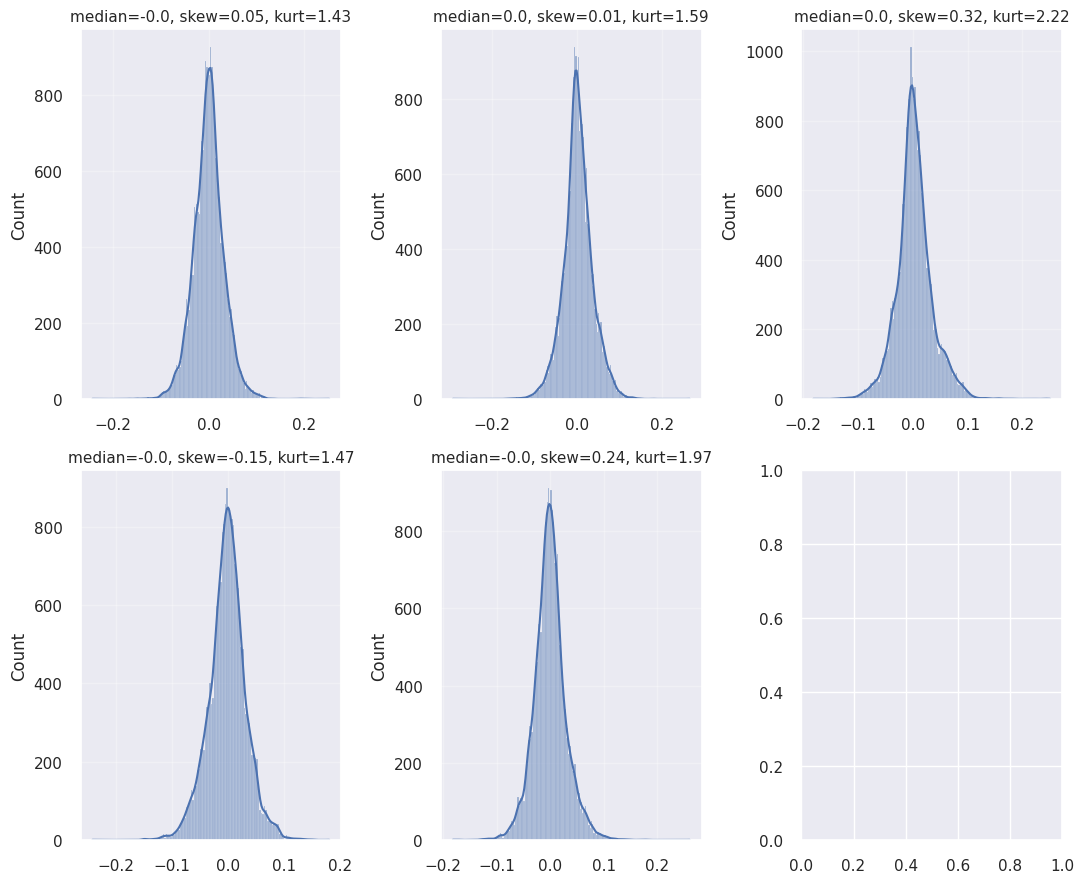

In [269]:
%%time
print("\n🔎 Checking if taking log returns have any impact on the correlation distribution")

f, ax = plt.subplots(2,3, figsize=(11, 9))

log_returns = generate_log_returns_dataframe(train, 1)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[0][0])

log_returns = generate_log_returns_dataframe(train, 4)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[0][1])

log_returns = generate_log_returns_dataframe(train, 10)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[0][2])

log_returns = generate_log_returns_dataframe(train, 20)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[1][0])

log_returns = generate_log_returns_dataframe(train, 30)
plot_target_feature_correlation_matrix(train, labels, pairs, correlation_threshold=0.5, ax=ax[1][1])

plt.tight_layout()
plt.show()

# Feature Engineering

In [ ]:
# Specific imports for this section

import networkx as nx

In [41]:
def date_features(df: pd.DataFrame):
    if 'date_id' not in df.columns:
        print("❗column date_id not found in the dataframe")
        raise

    day_of_week = df['date_id'] % 7
    month = (df['date_id'] // 30) % 12
    quarter = month // 3
    day_of_month = df['date_id'] % 30

    is_weekend = day_of_week.isin([5,6]).astype(int)
    is_month_start = (day_of_month == 0).astype(int)
    is_month_end = (day_of_month == 29).astype(int)

    columns = list(df.columns) + ['day_of_week', 'month', 'quarter', 'day_of_month', 'is_weekend', 'is_month_start', 'is_month_end']
    df = pd.concat([df, day_of_week, month, quarter, day_of_month, is_weekend, is_month_start, is_month_end], axis=1)
    df.columns = columns

    return df

def dispersion_of_correlated_instruments(df: pd.DataFrame, correlation_threshold: int):
    corr = train[[col for col in train.columns if col != 'date_id']].corr()

    # Construct a Graph with columns pairs as edges for pairs with high correlation
    G = nx.Graph()
    for i in corr.columns:
        for j in corr.columns:
            if i != j and np.abs(corr.loc[i, j]) > correlation_threshold:
                G.add_edge(i, j)
    
    # Get connected components (each is a cohort)
    cohorts = list(nx.connected_components(G))    
    print(f"\n🌐 Number of cohorts founds: {len(cohorts)}\n")

    # Generate std, skew and kurtosis for each of those cohorts on a daily basis (axis=1)
    dispersion_dict = {}
    for idx, cohort in enumerate(cohorts):
        group = train[list(cohort)]
        dispersion_dict[f'Cohort_{idx}'] = pd.DataFrame({
            'std': group.std(axis=1),
            'skew': group.skew(axis=1),
            'kurtosis': group.kurt(axis=1)  # or .kurtosis(axis=1)
        })

    return dispersion_dict

def plot_dispersion_dict(dispersion_dict):
    fig, ax = plt.subplots(figsize=(11,9))
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, len(dispersion_dict)))
    for i, (cohort, df) in enumerate(dispersion_dict.items()):
        if i == 0:
            df['std'].plot(ax=ax, label=cohort, color=colors[i])
        else:
            ax_i = ax.twinx()
            df['std'].plot(ax=ax_i, label=cohort, color=colors[i])
                    
            # Hide extra y-axis
            ax_i.get_yaxis().set_visible(False)
            ax_i.spines["right"].set_visible(False)
    
    # Show only one legend
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper left')
    
    # plt.legend()
    plt.tight_layout()
    plt.title("Daily Standard Deviation per Cohort")
    plt.show()


🌐 Number of cohorts founds: 40



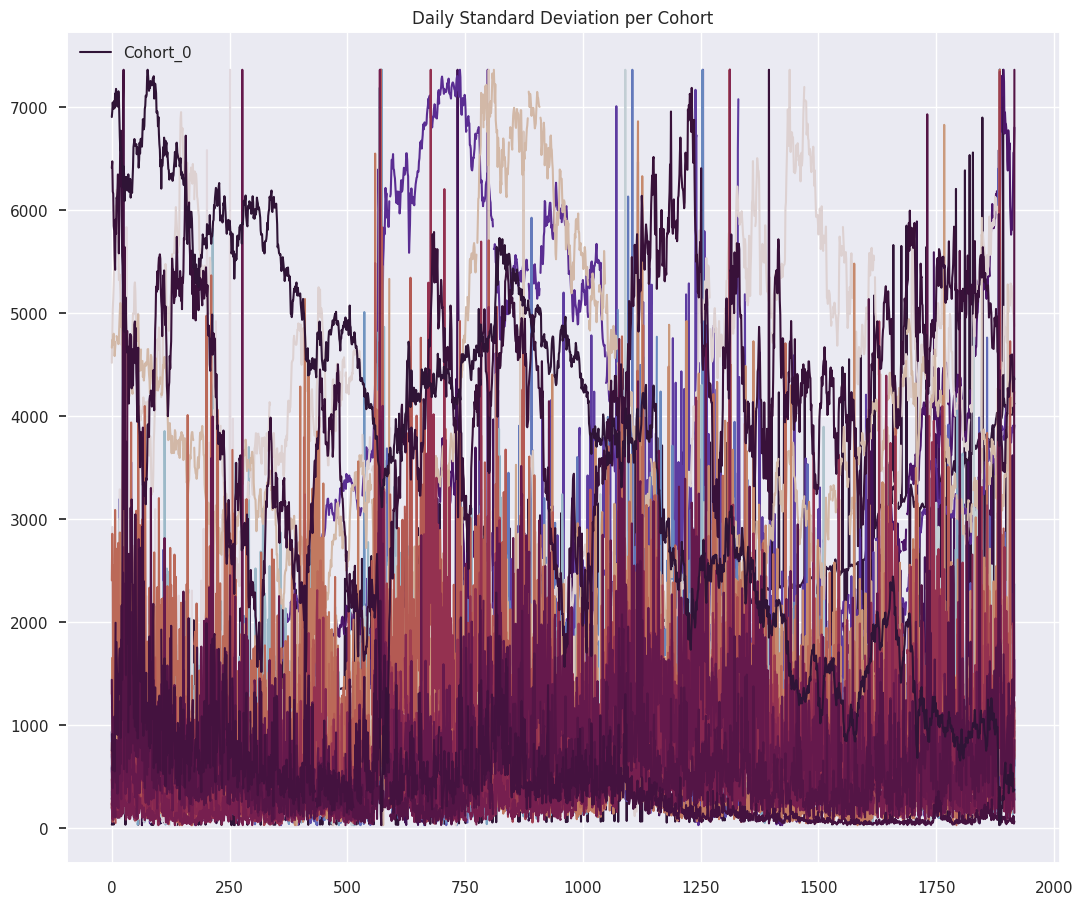

In [42]:
print(f"\n🌐 Analysing dispersion of correlated instruments\n")

dispersion_dict = dispersion_of_correlated_instruments(train, 0.95)
plot_dispersion_dict(dispersion_dict)


❗no strong correlation found for the set threshold of 50%



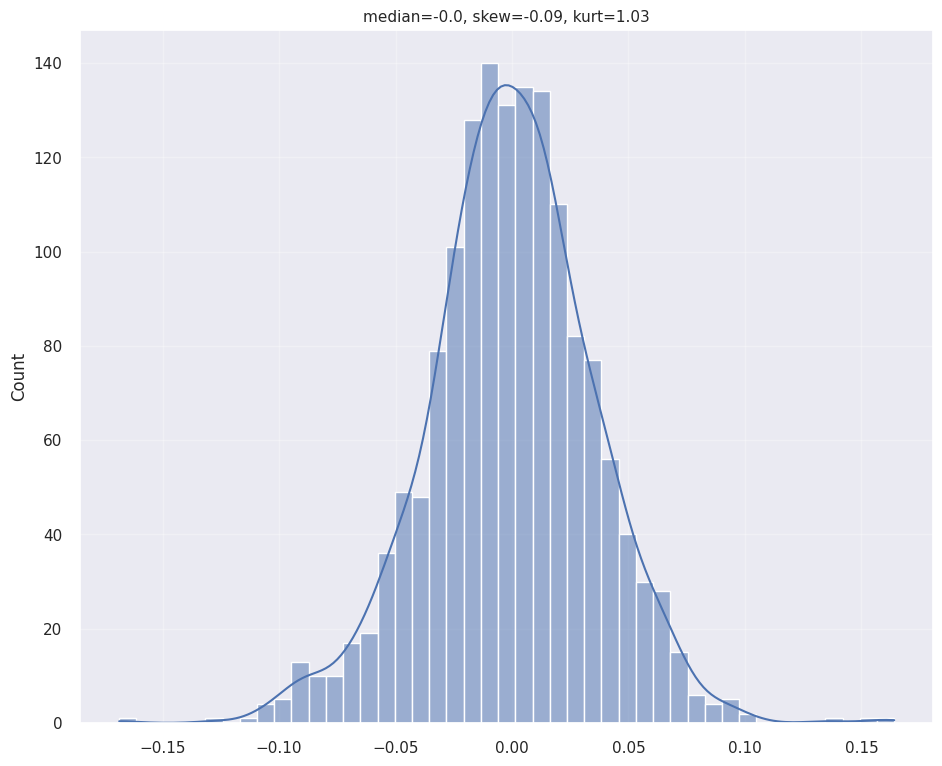

In [57]:
print(f"\n🌐 Target - feature analysis of dispersion (std) of cohort_0 with all targets\n")

index = dispersion_dict['Cohort_0']['std'].index

dispersion_df_std = pd.DataFrame([df['std'] for cohort, df in dispersion_dict.items()], index=dispersion_dict.keys(), columns=index).transpose()

plot_target_feature_correlation_matrix(dispersion_df_std, labels, pairs, correlation_threshold=0.5)

# Feature Importance

In [4]:
# Specific imports for this section

from sklearn.ensemble import GradientBoostingRegressor

In [5]:

def handle_missing_values(train: pd.DataFrame, target: pd.Series):
    X, Y = train.loc[target.notna()], target.loc[target.notna()]
    
    return X.fillna(0), Y

def bulk_feature_importance_from_hgb(train: pd.DataFrame, labels: pd.DataFrame, pairs: pd.DataFrame,
                                     max_iter=100, number_of_targets_per_lag=None, target_cols=None,
                                     features=None, debug=False):
    """
    Using HistGradientBoostingRegressor for feature importance
    We iterate over randomly chose targets
    or if target_cols is specified, we iterate over those
    """

    # Initialize target_cols_
    target_cols_=[]
    
    if (target_cols is not None) and (len(target_cols_)==0):
        target_cols_=target_cols

    if (number_of_targets_per_lag is not None) and (len(target_cols_)==0):
        sample_pairs = pairs.groupby('lag').sample(n=number_of_targets_per_lag, random_state=42)
        target_cols_ = sample_pairs['target'].tolist()

    if len(target_cols_)==0:
        target_cols_ = [x for x in labels.columns if x != 'date_id']

    # Initialize features_
    features_=[]
    if features is None:
        features_ = [x for x in train.columns if x != 'date_id']
    else:
        features_ = features

    # Initialize feature_importance_matrix 
    feature_importance_matrix = np.zeros((len(features_), len(target_cols_)))
    
    print("Training HistGradientBoostingRegressor...")
    for i, col in enumerate(target_cols_):
        if i%50 == 0:
            print(f"Processing target {i+1}/{len(target_cols_)}")

        params = {
            "n_estimators": 500,
            "max_depth": 4,
            "min_samples_split": 5,
            "learning_rate": 0.01,
            "loss": "squared_error",
        }
        
        model = GradientBoostingRegressor(**params)
        if debug:
            print("len of features: ", len(features_))
            print("Is train empty?: ", train[features_].empty)
            print("target_col: ", col)
            print("Is labels empty?: ", labels[col].empty)

        # Handle missing values in target
        X , Y = handle_missing_values(train[features_], labels[col])

        if debug:
            print("Is X empty?: ", X.empty)
            print("Is Y empty?: ", Y.empty)
            # print("X : ", X)
            print("Y : ", Y)
        
        model.fit(X , Y)
        if debug:
            print("model dir: ", dir(model))
            print("model dir: ", model.feature_names_in_)
            print("_compute_partial_dependence_recursion: ", model._compute_partial_dependence_recursion())
        
        feature_importance_matrix[:, i] = model.feature_importances_
            

    return pd.DataFrame(
        feature_importance_matrix, 
        index=X.columns, 
        columns=y_df.columns
    )

In [ ]:
%%time
feature_importance_matrix = bulk_feature_importance_from_hgb(train, labels, pairs, number_of_targets_per_lag=4, debug=False)
feature_importance_matrix

Training HistGradientBoostingRegressor...
Processing target 1/16
